In [5]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import math
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np
 
from funciones import read_data, calcular_distancia, calcular_matriz_dist, calcular_largo_ruta
from instancia import ubis, cap_tpte, info_locales
from instancia import G, color_nodos, color_arcos, ancho_edges
random.seed(42)
np.random.seed(42)

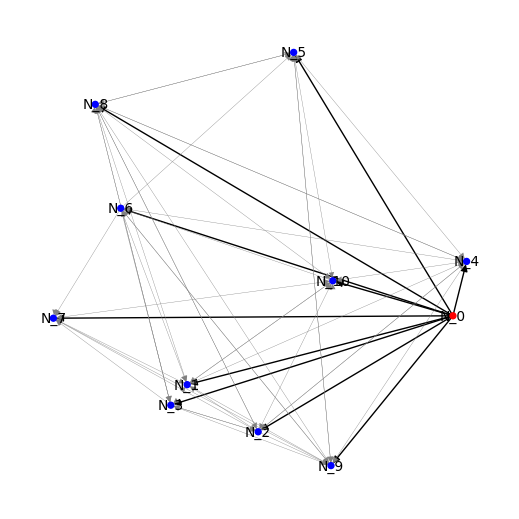

In [7]:
plt.figure(figsize=(5,5))

pos=nx.get_node_attributes(G,'pos')
nx.draw(G, pos=pos, with_labels=True, node_size=18, font_size=10, node_color=color_nodos, width=ancho_edges, edge_color=color_arcos)
plt.show()

In [17]:
matriz_dst = calcular_matriz_dist(G)

{'N_0': {'N_1': 297.5113443215233, 'N_2': 234.54637068179076, 'N_3': 318.709899438345, 'N_4': 47.43416490252569, 'N_5': 279.5514263959317, 'N_6': 375.69402444010205, 'N_7': 439.00455578501686, 'N_8': 430.20227800419656, 'N_9': 182.5705343148231, 'N_10': 135.14806694880988, 'N_0': inf}, 'N_1': {'N_4': 323.5011591942137, 'N_5': 298.8544796385023, 'N_6': 163.23296235748464, 'N_7': 156.95222202950808, 'N_8': 253.03161857759991, 'N_9': 171.618763542918, 'N_10': 181.64801127455263, 'N_0': inf, 'N_1': inf, 'N_2': inf, 'N_3': inf}, 'N_2': {'N_1': 87.20665112249179, 'N_3': 98.48857801796105, 'N_4': 268.9274995235705, 'N_5': 316.4127051810657, 'N_7': 243.8462630429263, 'N_8': 324.7799254880141, 'N_9': 84.75848040166836, 'N_10': 149.4958193395387, 'N_0': inf, 'N_2': inf, 'N_6': inf}, 'N_3': {'N_1': 24.758836806279895, 'N_2': 98.48857801796105, 'N_7': 147.73286702694156, 'N_8': 262.4690457939755, 'N_9': 182.96447742663054, 'N_10': 205.65261972559455, 'N_0': inf, 'N_3': inf, 'N_4': inf, 'N_5': inf,

In [122]:
list(info_locales['r'])

[87, 27, 10, 55, 71, 69, 79, 43, 77, 63]

In [152]:
def simular_demanda(data, dist="d"):
    demanda = {}
    for i in range(0, len(data)):
        if dist == "p":
            demanda[i+1] = int(round(np.random.poisson(data[i]),0))
        elif dist == "n":
            demanda[i+1] = int(round(np.random.normal(data[i], data[i]/10),0))
        elif dist == "u":
            demanda[i+1] = int(round(np.random.uniform(data[i]/2, data[i]*1.5),0))
        elif dist == "d":
            print(i+1, ":", data[i])
            demanda[i+1] = int(round(data[i],0))
    demanda[0] = 0
    return demanda

dem = simular_demanda(list(info_locales['r']), dist="n")


In [ ]:
def aplicar_politica_estacionaria(G, info_locales,matriz_dst):
    V = 0
    demanda = simular_demanda(info_locales['r'][1:],"d")
    for i in range(1,len(info_locales)):
        V += 
    # Definimos el inventario del día de cada nodo



In [154]:
'''NEAREST NEIGHBOR ALGORITHM FOR VRP'''
def nearest_neighbor(G, dist_matrix, demands, capacity):
    """
    Apply the Nearest Neighbor heuristic to find initial routes for VRP.
    """
    nodos = list(G.nodes)
    N = len(nodos)
    visitados = np.zeros(N, dtype=bool)
    rutas = []

    while np.sum(visitados) < N:
        nodo_actual = 0
        capacidad_actual = 0
        ruta = [nodo_actual]
        visitados[nodo_actual] = True

        while capacidad_actual + demands[nodo_actual] <= capacity:
            actual = f"N_{ruta[-1]}"
            cercano = None
            min_dist = float('inf')

            for vecino in np.where(~visitados)[0]:
                id_vecino = f"N_{vecino}"
                print(vecino)
                print(id_vecino)
                print(actual)
                print(dist_matrix[actual][id_vecino])
                print(demands[vecino])
                # print(vecino, id_vecino, actual, dist_matrix[actual][id_vecino], demands[vecino])
                if demands[vecino] + capacidad_actual <= capacity and dist_matrix[actual][id_vecino] < min_dist:
                    cercano = vecino
                    min_dist = dist_matrix[actual][id_vecino]
                
            if cercano is None:
                break

            ruta.append(cercano)
            visitados[cercano] = True
            capacidad_actual += demands[cercano]

            ruta.append(ruta)

    return rutas

    # num_points = len(dist_matrix)
    # visited = np.zeros(num_points, dtype=bool)
    # routes = []

    # while np.sum(visited) < num_points:
    #     current_node = 0  # Start at node 0
    #     current_capacity = 0
    #     route = [current_node]
    #     visited[current_node] = True

    #     while current_capacity + demands[current_node] <= capacity:
    #         current = route[-1]
    #         nearest = None
    #         min_dist = float('inf')

    #         for neighbor in np.where(~visitados)[0]:
    #             if demands[neighbor] + current_capacity <= capacity and dist_matrix[current, neighbor] < min_dist:
    #                 nearest = neighbor
    #                 min_dist = dist_matrix[current, neighbor]

    #         if nearest is None:
    #             break

    #         route.append(nearest)
    #         visitados[nearest] = True
    #         current_capacity += demands[nearest]

    #     routes.append(route)

    # return routes


In [155]:
matriz_dst = calcular_matriz_dist(G)
demanda = simular_demanda(list(info_locales['r']), dist="n")
cap_tpte = cap_tpte
G = G
nearest_neighbor(G, dist_matrix=matriz_dst, demands=demanda, capacity = cap_tpte)

1
N_1
N_0
297.5113443215233
79
2
N_2
N_0
234.54637068179076
29
3
N_3
N_0
318.709899438345
11
4
N_4
N_0
47.43416490252569
50
5
N_5
N_0
279.5514263959317
78
6
N_6
N_0
375.69402444010205
72
7
N_7
N_0
439.00455578501686
85
8
N_8
N_0
430.20227800419656
51
9
N_9
N_0
182.5705343148231
75
10
N_10
N_0
135.14806694880988
58
1
N_1
N_[0, 4, [...]]


KeyError: 'N_[0, 4, [...]]'

In [ ]:
'''TWO OPT ALGORITHM FOR VRP'''

def two_opt(routes, dist_matrix, num_iterations):
    best_routes = routes.copy()

    for _ in range(num_iterations):
        selected_route_idx = np.random.randint(0, len(routes))
        selected_route = routes[selected_route_idx]

        i, j = np.random.randint(1, len(selected_route) - 1, size=2)
        if j < i:
            i, j = j, i

        new_route = selected_route.copy()
        new_route[i:j] = selected_route[j - 1: i - 1: -1]  # Reverse the path between i and j

        new_routes = routes.copy()
        new_routes[selected_route_idx] = new_route

        if calculate_total_distance(new_routes[selected_route_idx], dist_matrix) < calculate_total_distance(
                best_routes[selected_route_idx], dist_matrix
        ):
            best_routes = new_routes

    return best_routes

def vrp_solver2(filename, sheet_name, capacity, num_iterations):
    """
    Solve the VRP using the provided filename for coordinates, vehicle capacity,
    and number of iterations for the two-opt optimization.
    """
    coordinates, demands = read_excel_file(filename, sheet_name)
    dist_matrix = calculate_distance_matrix(coordinates)
    routes = nearest_neighbor(dist_matrix, demands, capacity)

    for i in range(len(routes)):
        route = routes[i]
        optimized_route = two_opt([route], dist_matrix, num_iterations)[0]
        routes[i] = optimized_route

    formatted_routes = format_output(routes)
    return formatted_routes

filename = r"C:\Users\Firdaus\Documents\DATA VRP ASSIGNMENT.xlsx"
sheet_name = "vrp 421"  # Specify the name of the sheet or its index
capacity = 200 # Specify the capacity of the vehicle
num_iterations = 100000
solution=vrp_solver2(filename, sheet_name, capacity, num_iterations)
print(solution)

for route in solution:
    print(route)